# Manifold GP Supervised Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth = groundtruth_from_samples(vertices)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

### Trainset

In [3]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
num_train = 50
train_idx = rand_idx[:num_train]
train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]

#### Noise Features

In [4]:
noise_train_x = 0.0
train_x += noise_train_x * torch.randn(num_train, n)

#### Noise Labels

In [5]:
noise_train_y = 0.0
train_y += noise_train_y * torch.randn(num_train)

#### Normalize Features

#### Normalize Labels

In [6]:
%%capture
mu_y, std_y = train_y.mean(), train_y.std()
train_y.sub_(mu_y).div_(std_y)

### Testset

In [7]:
test_idx = rand_idx[num_train:]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

#### Noise Features

In [8]:
noise_test_x = 0.0
test_x += noise_test_x * torch.randn(m-num_train, n)

#### Noise Labels

In [9]:
noise_test_y = 0.0
test_y += noise_test_y * torch.randn(m-num_train)

### Move Data to Device

In [10]:
sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

## Likelihood

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

## Riemann Model

### Kernel

In [12]:
kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=2,
        nodes=train_x,
        neighbors=int(num_train*0.25),
        modes=int(num_train*0.25),
        support_kernel=gpytorch.kernels.RBFKernel(),
        epsilon_prior=None,  # GammaPrior(gamma_concentration, gamma_rate),
        lengthscale_prior=None  # InverseGammaPrior(igamma_concentration, igamma_rate)
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

### Model

In [13]:
model = RiemannGP(train_x, train_y, likelihood, kernel).to(device)

### Hyperparameters

In [14]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-5,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 0.5,
    'covar_module.outputscale': 1.0,
    'covar_module.base_kernel.support_kernel.lengthscale': 1.0,
}
model.initialize(**hypers)

### Train

In [15]:
model.manifold_informed_train(lr=1e-2, iter=100, verbose=True)

Iteration: 0, Loss: 65192.410, Noise Variance: 0.003, Signal Variance: 1.000, Lengthscale: 0.500, Epsilon: 0.500
Iteration: 1, Loss: 62617.074, Noise Variance: 0.003, Signal Variance: 1.003, Lengthscale: 0.504, Epsilon: 0.496
Iteration: 2, Loss: 60146.730, Noise Variance: 0.003, Signal Variance: 1.006, Lengthscale: 0.508, Epsilon: 0.492
Iteration: 3, Loss: 57778.793, Noise Variance: 0.003, Signal Variance: 1.009, Lengthscale: 0.512, Epsilon: 0.488
Iteration: 4, Loss: 55510.758, Noise Variance: 0.003, Signal Variance: 1.013, Lengthscale: 0.516, Epsilon: 0.484
Iteration: 5, Loss: 53339.855, Noise Variance: 0.003, Signal Variance: 1.016, Lengthscale: 0.520, Epsilon: 0.481
Iteration: 6, Loss: 51263.289, Noise Variance: 0.003, Signal Variance: 1.019, Lengthscale: 0.524, Epsilon: 0.477
Iteration: 7, Loss: 49278.117, Noise Variance: 0.003, Signal Variance: 1.022, Lengthscale: 0.528, Epsilon: 0.473
Iteration: 8, Loss: 47381.297, Noise Variance: 0.003, Signal Variance: 1.025, Lengthscale: 0.532

Iteration: 77, Loss: 8187.202, Noise Variance: 0.004, Signal Variance: 1.158, Lengthscale: 0.725, Epsilon: 0.308
Iteration: 78, Loss: 8061.989, Noise Variance: 0.004, Signal Variance: 1.159, Lengthscale: 0.727, Epsilon: 0.307
Iteration: 79, Loss: 7939.850, Noise Variance: 0.004, Signal Variance: 1.160, Lengthscale: 0.728, Epsilon: 0.306
Iteration: 80, Loss: 7820.675, Noise Variance: 0.004, Signal Variance: 1.161, Lengthscale: 0.730, Epsilon: 0.304
Iteration: 81, Loss: 7704.364, Noise Variance: 0.004, Signal Variance: 1.162, Lengthscale: 0.731, Epsilon: 0.303
Iteration: 82, Loss: 7590.812, Noise Variance: 0.004, Signal Variance: 1.163, Lengthscale: 0.733, Epsilon: 0.301
Iteration: 83, Loss: 7479.931, Noise Variance: 0.004, Signal Variance: 1.164, Lengthscale: 0.735, Epsilon: 0.300
Iteration: 84, Loss: 7371.624, Noise Variance: 0.004, Signal Variance: 1.165, Lengthscale: 0.736, Epsilon: 0.299
Iteration: 85, Loss: 7265.806, Noise Variance: 0.004, Signal Variance: 1.166, Lengthscale: 0.738

## Evaluation

In [16]:
%%capture
likelihood.eval()
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # manifold
    preds = model(sampled_x) # preds = likelihood(model(test_x))

    # ambient
    resolution = 100
    y, x = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution))
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    preds_grid = model(grid_x) # preds_grid = likelihood(model(grid_x))
    
    # metrics
    preds_test = model(test_x) # preds_test = likelihood(model(test_x))
    rmse = (preds_test.mean.mul(std_y).add(mu_y) - test_y).square().sum().sqrt()
    nll = -preds_test.log_prob(test_y)

## Plot

### Ground Truth

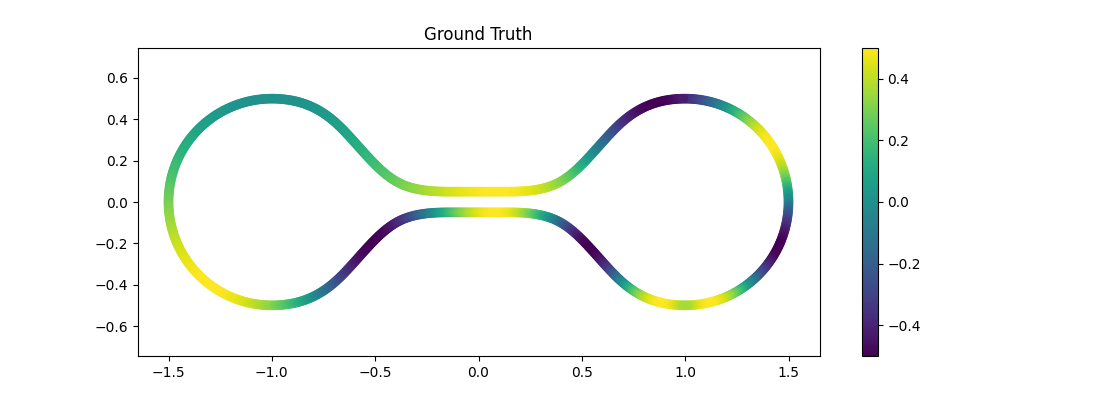

In [17]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=sampled_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')

### Posterior Mean

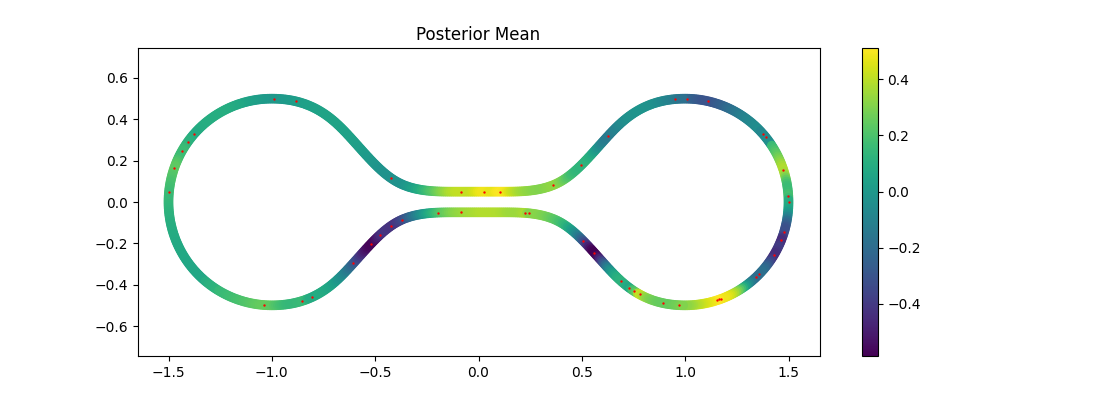

In [18]:
with torch.no_grad():
    posterior_mean = preds.mean.mul(std_y).add(mu_y).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_mean)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Kernel Evaluation

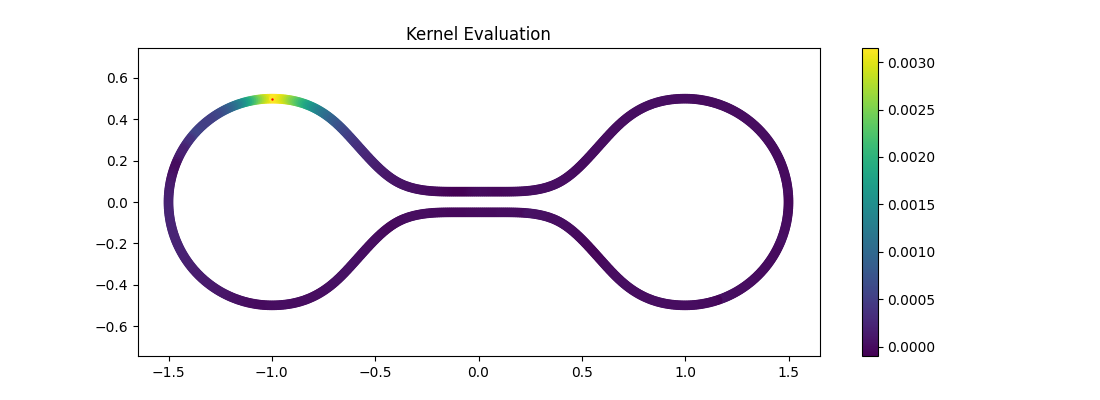

In [19]:
with torch.no_grad():
    kernel_eval = model.covar_module(sampled_x[0, :].unsqueeze(0), sampled_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=kernel_eval)
    ax.scatter(sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

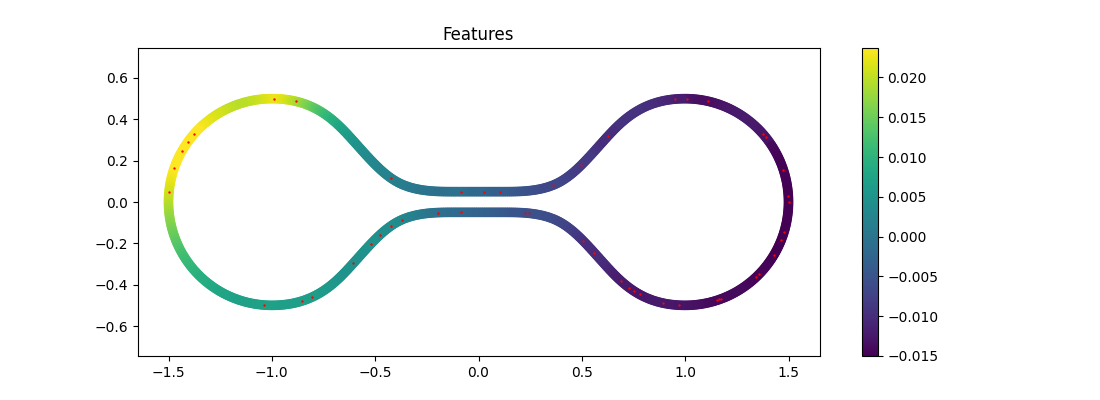

In [20]:
with torch.no_grad():
    c = 10.0
    features = kernel.base_kernel.features(sampled_x, c=c)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=features)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Variance

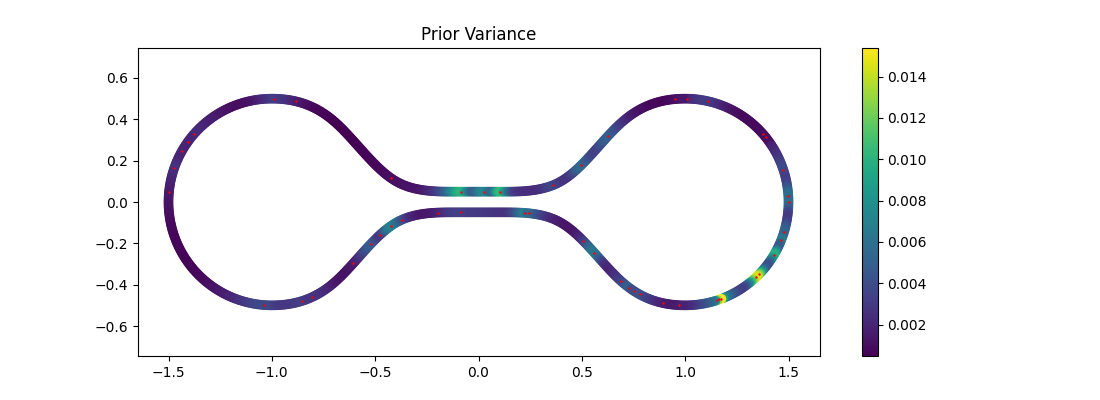

In [21]:
with torch.no_grad():
    prior_var = model.covar_module(sampled_x, sampled_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=prior_var)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Variance')

### Posterior Standard Deviation

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:276: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


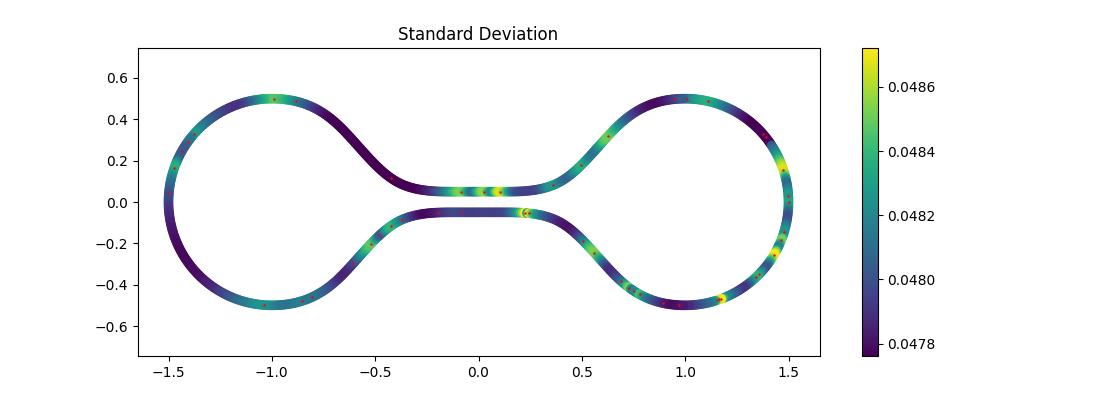

In [22]:
with torch.no_grad():
    posterior_std = preds.stddev.mul(std_y).add(mu_y).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c=posterior_std)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

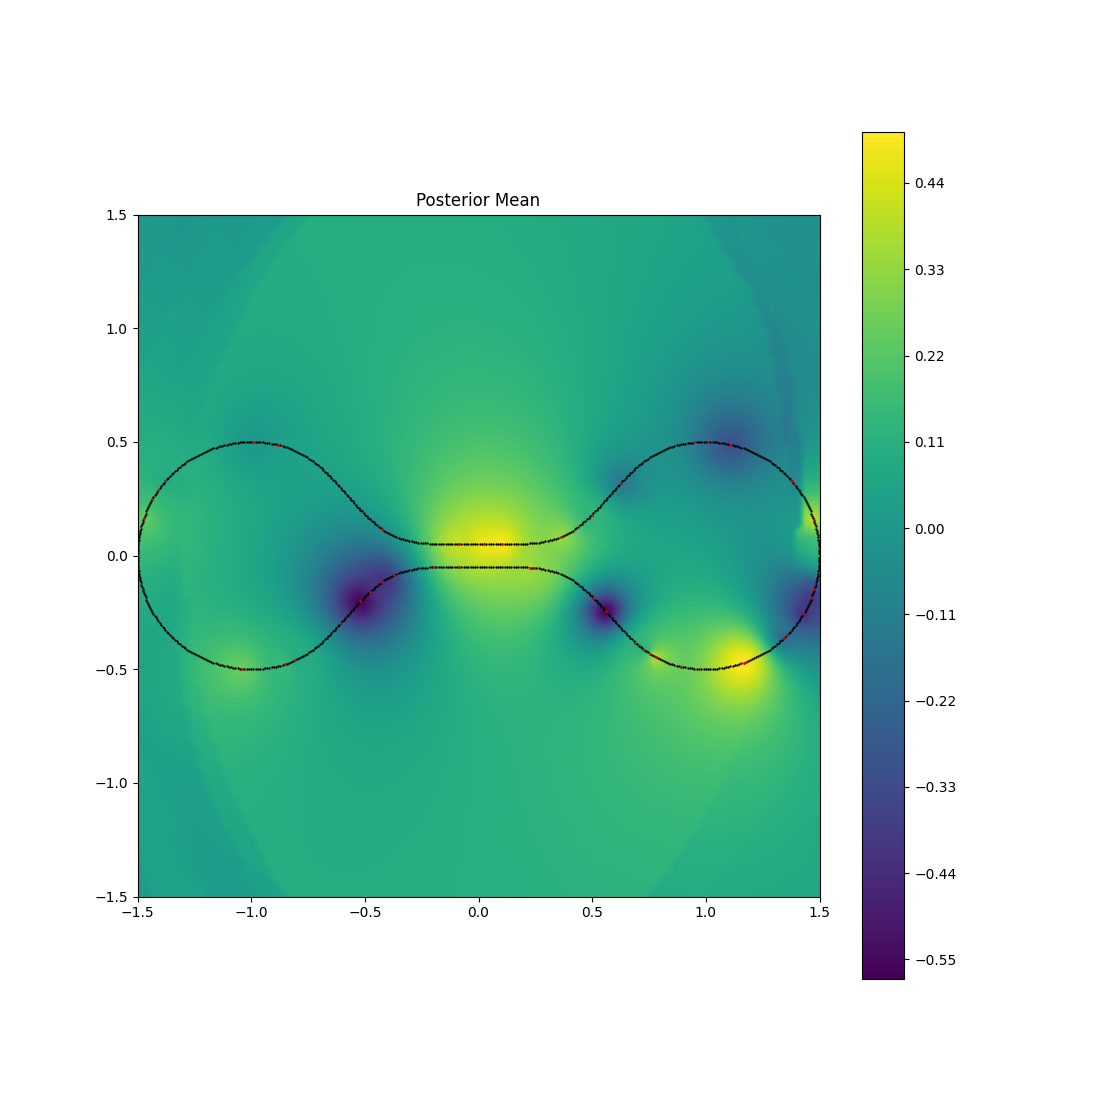

In [23]:
with torch.no_grad():
    posterior_mean_grid = preds_grid.mean.mul(std_y).add(mu_y).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

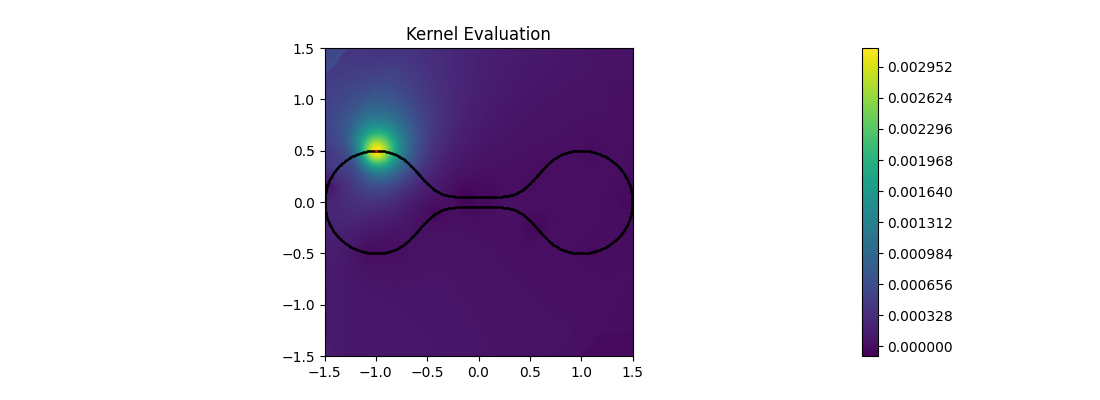

In [24]:
with torch.no_grad():
    kernel_eval_grid = model.covar_module(sampled_x[0, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Features

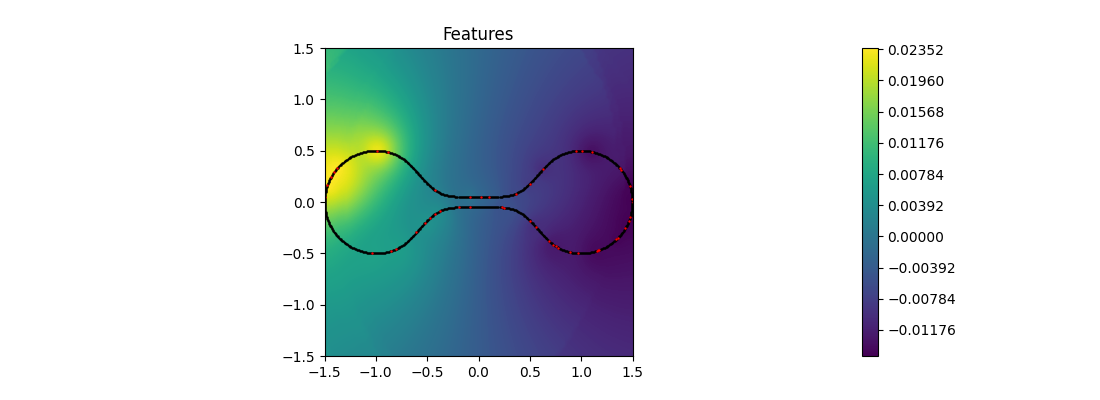

In [25]:
with torch.no_grad():
    c = 10.0
    features_grid = kernel.base_kernel.features(grid_x, c=c)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), features_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_sample_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((sampled_x.cpu().numpy()[0, 0], sampled_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Features')

### Ambient Prior Variance

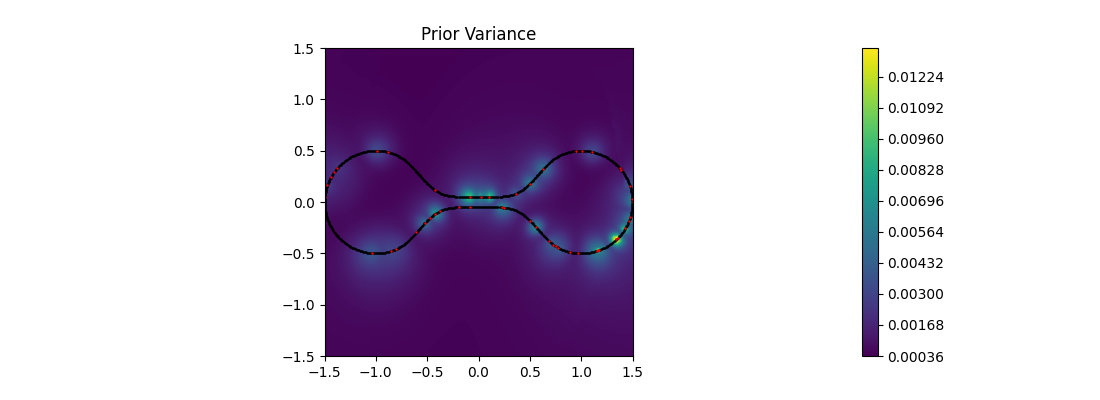

In [26]:
with torch.no_grad():
    prior_var_grid = model.covar_module(grid_x, grid_x).evaluate().diag().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

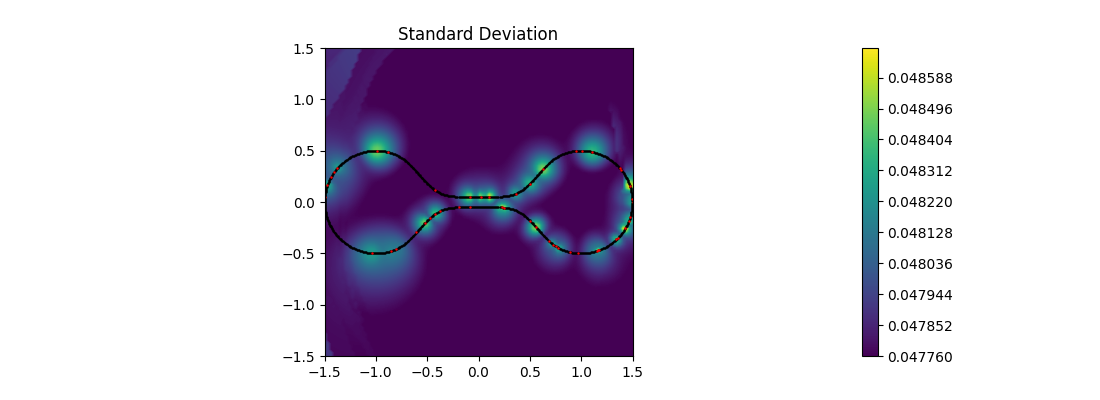

In [27]:
with torch.no_grad():
    posterior_std_grid = preds_grid.stddev.mul(std_y).add(mu_y).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(sampled_x.cpu().numpy()[:, 0], sampled_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')